In [43]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector
warnings.filterwarnings('ignore', category=DeprecationWarning)



In [44]:
def stateprep(x_train, y_train, x_test, d):

  """
  x_train: array of training features (n_samples, 2)
  y_train: array of binary training labels (n_samples, )
  x_test: array of test features (2, )
  d: number of control qubits. Generates 2^d transformations to training data
  """

  N = x_train.shape[0]

  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')

  stateprep = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)

  #create uniform superposition of control qubits
  for i in range(d):
    stateprep.h(i)


  #initialize training data
  for i in range(x_train.shape[0]):
    stateprep.initialize(x_train[i]/np.linalg.norm(x_train[i]), i+d)

  for i in range(y_train.shape[0]):
    if y_train[i] == 1:
      stateprep.initialize([0, 1], i+d+x_train.shape[0])
    else:
      stateprep.initialize([1, 0], i+d+x_train.shape[0])

  #initialize test data
  stateprep.initialize(x_test/np.linalg.norm(x_test), d+2*N)


  stateprep.barrier()

  return stateprep

In [45]:
def superposition_sampler(x_train, y_train, x_test, d):

  """
  x_train: array of training features
  y_train: array of binary training labels
  x_test: array of test features
  d: number of control qubits. Generates 2^d transformations to training data
  """
  N = x_train.shape[0]

  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')

  sampler = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)

  for i in range(d):
    if(i % 2 == 0):
      sampler.cswap(i, i+2, i+4)
      sampler.cswap(i, i+2+N, i+4+N)
      sampler.x(i)
      sampler.cswap(i, i+3, i+5)
      sampler.cswap(i, i+3+N, i+5+N)
      sampler.barrier()
    else:
      sampler.x(i)
      sampler.cswap(i, i+3, i+4)
      sampler.cswap(i, i+7, i+8)
      sampler.barrier()

  return sampler

In [46]:
def cosine_classifier(N, d):

  """
  N: number of train samples
  d: number of control qubits. Generates 2^d transformations to training data
  """
  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')

  f = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)
  f.h(prediction_reg[0])
  f.cswap(prediction_reg[0], x_train_reg[N-1], x_test_reg[0])
  f.h(prediction_reg[0])
  f.cx(y_train_reg[N-1], prediction_reg[0])
  f.barrier()
  
  return f

In [47]:
def measure():
    
    prediction_reg = QuantumRegister(1, 'prediction')
    cr = ClassicalRegister(1, name = "cr")
    m = QuantumCircuit(prediction_reg, cr)
    m.measure(prediction_reg[0], cr[0])
    
    return m

In [48]:
def plot_data(x_train, y_train, x_test):
    '''
    x_train: (n_samples, 2)
    y_train: (n_samples, )
    x_test: (2, )
    '''
    x_test = x_test[np.newaxis, :]
    x = np.concatenate((x_train, x_test), axis = 0)
    y = np.concatenate((y_train, np.asarray([-1])), axis = 0)
    
    data = pd.DataFrame(columns = ['x1', 'x2', 'y'])
    data['x1'] = x[:, 0]
    data['x2'] = x[:, 1]
    data['y'] = y
    
    sns.catplot(x='x1', y='x2', hue='y', data=data)
    
    return

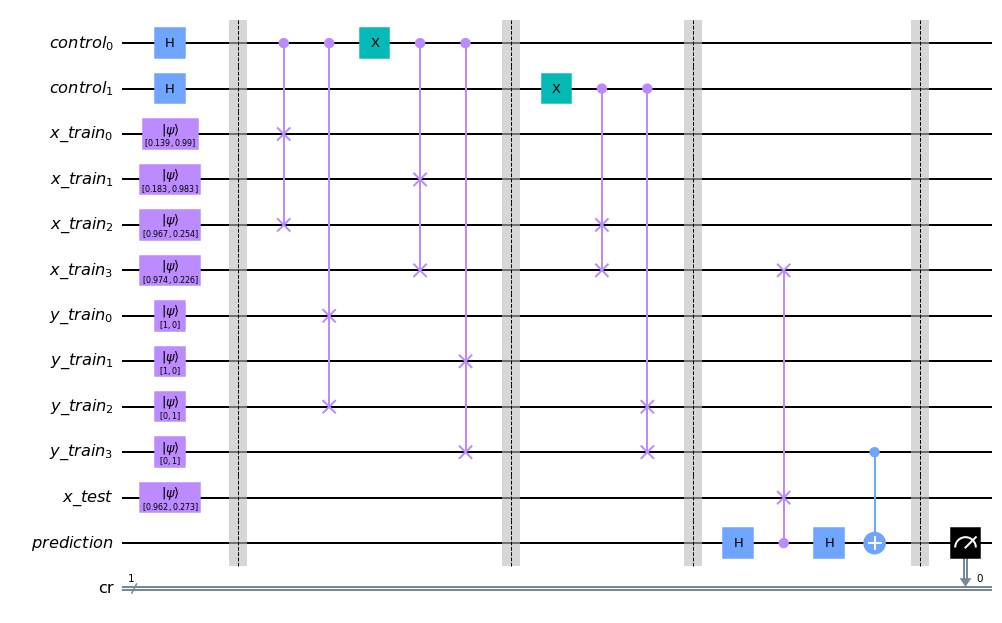

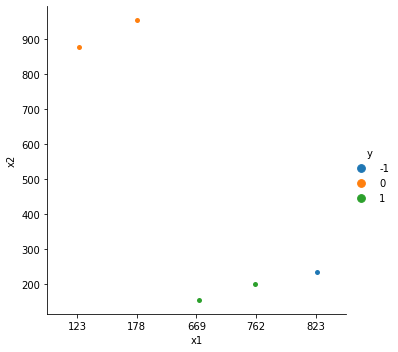

In [49]:
x_train = [[123, 879], [178, 954], [762, 200], [669, 155]] 
x_train = np.asarray(x_train)

y_train = [0, 0, 1, 1]
y_train = np.asarray(y_train)

x_test = [823, 234]
x_test = np.asarray(x_test)

plot_data(x_train, y_train, x_test)



N = x_train.shape[0]
d = 2

circ = stateprep(x_train, y_train, x_test, d)
circ += superposition_sampler(x_train, y_train, x_test, d)
circ.draw(output = 'mpl')


circ += cosine_classifier(N, d)
circ += measure()
circ.draw(output = 'mpl')

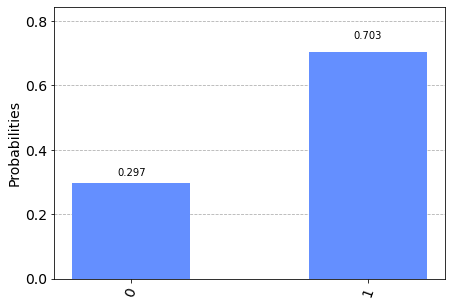

In [34]:
# train and predict
plot_histogram(execute(circ, Aer.get_backend('qasm_simulator'), shots=2000).result().get_counts())